In [1]:
import numpy as np
import matplotlib.pyplot as plt
from riemann import *

In [2]:
class Grid(object):
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):
        self.ng = ng
        self.nx = nx 

        self.xmin = xmin
        self.xmax = xmax
        self.ilo = ng
        self.ihi = ng + nx - 1

        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx
        self.a = np.zeros((nx + 2*ng, 3), dtype = np.float64)

    def fill_BCs(self):

        for i in range(self.ng):
            self.a[self.ilo-1-i,:] = self.a[self.ihi-i,:]
            self.a[self.ihi+1+i,:] = self.a[self.ilo+i,:]
    
    def init_cond(self,type = "Sod's problem"):
        if type == "Sod's problem":
        
            #rou component
            self.a[self.x < 0.5, 0] = 1.0
            self.a[self.x >= 0.5, 0] = 0.125
        
            #u component
            self.a[self.x < 0.5, 1] = 0.0
            self.a[self.x >= 0.5, 1] = 0.0
        
            #p component
            self.a[self.x < 0.5, 2] = 1.0
            self.a[self.x >= 0.5, 2] = 0.1
        
        if type == "double rarefaction":
            
            #rou component
            self.a[self.x < 0.5, 0] = 1.0
            self.a[self.x >= 0.5, 0] = 1.0
        
            #u component
            self.a[self.x < 0.5, 1] = -2.0
            self.a[self.x >= 0.5, 1] = 2.0
        
            #p component
            self.a[self.x < 0.5, 2] = 0.4
            self.a[self.x >= 0.5, 2] = 0.4
        
        if type == "strong shock":
            
            #rou component
            self.a[self.x < 0.5, 0] = 1.0
            self.a[self.x >= 0.5, 0] = 1.0
        
            #u component
            self.a[self.x < 0.5, 1] = 0.0
            self.a[self.x >= 0.5, 1] = 0.0
        
            #p component
            self.a[self.x < 0.5, 2] = 1000.0
            self.a[self.x >= 0.5, 2] = 0.01
        
        if type == "stationary shock":
            
            #rou component
            self.a[self.x < 0.5, 0] = 5.6698
            self.a[self.x >= 0.5, 0] = 1.0
        
            #u component
            self.a[self.x < 0.5, 1] = -1.4701
            self.a[self.x >= 0.5, 1] = -10.5
        
            #p component
            self.a[self.x < 0.5, 2] = 100.0
            self.a[self.x >= 0.5, 2] = 1.0
            
    

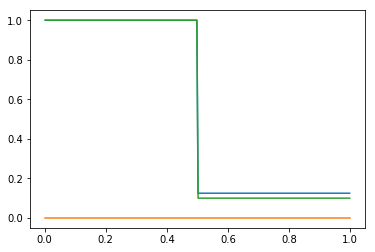

In [3]:
#test of the Grid class
mygrid = Grid(256,2)
mygrid.init_cond(type = "Sod's problem")
mygrid.fill_BCs()
plt.plot(mygrid.x[mygrid.ilo:mygrid.ihi+1],mygrid.a[mygrid.ilo:mygrid.ihi+1])
plt.show()
        

In [66]:
class Simulation(object):
    
    def __init__(self, q_grid, tmax, C=0.8, gamma=1.4,):
        self.q_grid = q_grid
        self.tmax = tmax
        self.C = C
        self.gamma = gamma
        
        #creat a grid for U, using gamma-law EOS
        self.U_grid = Grid(self.q_grid.nx, self.q_grid.ng)
        
        #rou
        self.U_grid.a[:,0] = self.q_grid.a[:,0]
        
        #rou*u
        self.U_grid.a[:,1] = self.q_grid.a[:,0]*self.q_grid.a[:,1]
        
        #rou*E
        self.U_grid.a[:,2] = (self.q_grid.a[:,2])/(self.gamma - 1) + 0.5/(self.U_grid.a[:,0])*(self.U_grid.a[:,1])**2
        
        self.U_grid.fill_BCs()
    
    #function to convert U to q,also using gamma-law EOS
    def utoq(self):
        self.q_grid.a[:,0] = self.U_grid.a[:,0]
        self.q_grid.a[:,1] = (self.U_grid.a[:,1])/(self.U_grid.a[:,0])
        self.q_grid.a[:,2] = (self.U_grid.a[:,2] - 0.5/(self.U_grid.a[:,0])*(self.U_grid.a[:,1])**2)*(self.gamma - 1)
    
    def deltat(self):
        # dt = C*dx/(max(abs(u_i)+c_i)), where the sound speed c = sqrt(gamma*p/rou)
        return self.C*self.q_grid.dx/(np.amax(np.absolute(self.q_grid.a[:,1]) + np.sqrt((self.gamma*self.q_grid.a[:,2])/(self.q_grid.a[:,0]))))
    
    def minmod(self,a,b):
        slope = np.zeros((3))
        for i in range(3):
            if abs(a[i]) < abs(b[i]) and (a[i])*(b[i]) > 0:
                slope[i] = a[i]
            elif abs(b[i]) < abs(a[i]) and (a[i])*(b[i]) > 0:
                slope[i] = b[i]
        return slope
    
    #compute A using U
    def utoa(self):
        
        #fill the ghost cells
        self.U_grid.fill_BCs()
                
        #convert u to q
        self.utoq()
                
        #compute the limited slopes
        dq = np.zeros((self.q_grid.nx + 2*self.q_grid.ng,3))
        
        #RHS i,(i+1),(i-1) are in range(0,nx+2*ng), thus LHS i is in range(1,nx+2*ng-1)
        for i in range(1,self.q_grid.nx + 2*self.q_grid.ng - 1):
            dq[i,:] = self.minmod(self.q_grid.a[i+1,:] - self.q_grid.a[i,:],\
                                    self.q_grid.a[i,:] - self.q_grid.a[i-1,:])

        #compute the value on left and right sides of the interface
        ql = np.zeros((self.q_grid.nx + 2*self.q_grid.ng,3))
        qr = np.copy(ql)
        
        #here ql[i] and qr[i] represent ql[i-1/2] and qr[i-1/2]
        #RHS (i-1) and q_i are in range(1,nx+2*ng-1),thus LHS i is in range(2,nx+2*ng-1)
        ql[2:self.q_grid.nx + 2*self.q_grid.ng-1] = self.q_grid.a[1:self.q_grid.nx + 2*self.q_grid.ng-2,:] + \
                                                             0.5*dq[1:self.q_grid.nx + 2*self.q_grid.ng-2,:]
        qr[2:self.q_grid.nx + 2*self.q_grid.ng-1] = self.q_grid.a[2:self.q_grid.nx + 2*self.q_grid.ng-1,:] - \
                                                             0.5*dq[2:self.q_grid.nx + 2*self.q_grid.ng-1,:]
        
        #solve the Riemann problem,f[i] represent F[i-1/2]
        #i is still in range(2,nx+2*ng-1)
        f = np.zeros((self.q_grid.nx + 2*self.q_grid.ng,3))
        for i in range(2,self.q_grid.nx + 2*self.q_grid.ng-1):
            f[i,:] = riemann(ql[i,:],qr[i,:],self.gamma)
                
        #compute A
        a = np.zeros((self.q_grid.nx + 2*self.q_grid.ng,3))
        
        #i and (i+1) are in range(2,nx+2*ng-1), thus i is in range(2,nx+2*ng-2)
        a[2:self.q_grid.nx + 2*self.q_grid.ng-2,:] = (f[2:self.q_grid.nx + 2*self.q_grid.ng-2,:] - f[3:self.q_grid.nx + 2*self.q_grid.ng-1,:])/self.q_grid.dx

        return a
        
        
    def evolve(self):
        
        t = 0.0
        while t < self.tmax:
            dt = self.deltat()
                        
            if t + dt > self.tmax:
                dt = self.tmax - t
            
            #compute a
            a = self.utoa()
            
            #record U_n
            U_n = np.copy(self.U_grid.a)
            
            #update U_star
            self.U_grid.a[self.U_grid.ilo:self.U_grid.ihi+1,:] += 0.5*dt*a[self.U_grid.ilo:self.U_grid.ihi+1,:]
            
            #compute A_star using U_star
            a = self.utoa()
            
            #updata U_n to U_n+1
            self.U_grid.a[self.U_grid.ilo:self.U_grid.ihi+1,:] = U_n[self.U_grid.ilo:self.U_grid.ihi+1,:] + dt*a[self.q_grid.ilo:self.q_grid.ihi+1,:]
            
            #fit BCs
            self.U_grid.fill_BCs()
            
            #convert U to q
            self.utoq()
            
            #updata time
            t += dt        
        
        return self.q_grid.x[self.q_grid.ilo:self.q_grid.ihi+1],self.q_grid.a[self.q_grid.ilo:self.q_grid.ihi+1,:]
            

In [67]:
#test of minmod function
sim = Simulation(mygrid,0.2)
x = np.array([1,2,3])
y = np.array([3,1,3])
result = sim.minmod(x,y)
print(result[:3])

[ 1.  1.  0.]


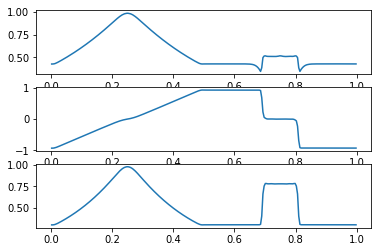

In [68]:
q_grid = Grid(256,2)
q_grid.init_cond(type = "Sod's problem")
sim = Simulation(q_grid,0.2)
x,a = sim.evolve()
plt.subplot(3,1,1)
plt.plot(x,a[:,0])
plt.subplot(3,1,2)
plt.plot(x,a[:,1])
plt.subplot(3,1,3)
plt.plot(x,a[:,2])
plt.show()

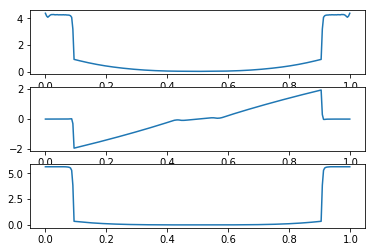

In [69]:
q_grid = Grid(256,2)
q_grid.init_cond(type = "double rarefaction")
sim = Simulation(q_grid,0.15)
x,a = sim.evolve()
plt.subplot(3,1,1)
plt.plot(x,a[:,0])
plt.subplot(3,1,2)
plt.plot(x,a[:,1])
plt.subplot(3,1,3)
plt.plot(x,a[:,2])
plt.show()

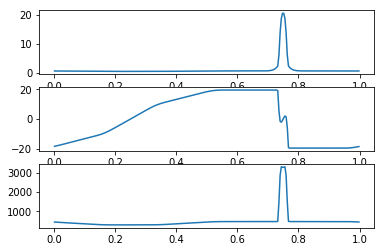

In [70]:
q_grid = Grid(256,2)
q_grid.init_cond(type = "strong shock")
sim = Simulation(q_grid,0.012)
x,a = sim.evolve()
plt.subplot(3,1,1)
plt.plot(x,a[:,0])
plt.subplot(3,1,2)
plt.plot(x,a[:,1])
plt.subplot(3,1,3)
plt.plot(x,a[:,2])
plt.show()

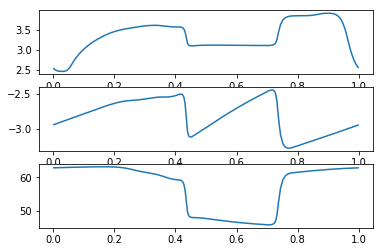

In [71]:
q_grid = Grid(256,2)
q_grid.init_cond(type = "stationary shock")
sim = Simulation(q_grid,1.0)
x,a = sim.evolve()
plt.subplot(3,1,1)
plt.plot(x,a[:,0])
plt.subplot(3,1,2)
plt.plot(x,a[:,1])
plt.subplot(3,1,3)
plt.plot(x,a[:,2])
plt.show()